In [309]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pickle
import time

import tensorflow as tf
import tensorflow.contrib.slim as slim
from tensorflow.contrib.slim import fully_connected as fc
#from sklearn.manifold import TSNE

import gensim
from gensim.models import FastText

# Pickle Functions

In [2]:
def save_obj(obj, name):
    with open('obj/' + name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)

def exist(name):
    return os.path.exists('obj/' + name + '.pkl')


In [10]:
total_data = load_obj('total_data')

# Phraser

### make phraser

In [39]:
dir_cleaned_news = "cleaned_news/"

In [41]:
def splitt(text):
    return text.split()

In [63]:
tickers = [i for i in os.listdir(dir_cleaned_news) if i.endswith(".csv")]
corpus = []
start = time.time()

for ticker in tickers:
    df = pd.read_csv(dir_cleaned_news + ticker, index_col=0)
    df = df.dropna()
    corpus += list(df['content'].apply(splitt))

In [75]:
save_obj(corpus, 'corpus')

In [74]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(corpus + list(total_data.lemmatized), min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[corpus + list(total_data.lemmatized)], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[corpus[0]]])

/home/qara/anaconda3/lib/python3.6/site-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['important', 'metric', 'look', 'stock', 'be', 'higher', 'relative', 'strength', 'rating', 'motorola_solution', 'msi', 'clear', 'benchmark', 'wednesday', 'jump', 'wednesday', 're', 'research', 'best', 'stock', 'buy', 'watch', 'keep', 'close', 'eye', 'relative', 'price', 'strength', 'exclusive', 'rating', 'investor', 'business', 'daily', 'track', 'price', 'action', 'worst', 'best', 'score', 'rating', 'show', 'stock', 'price', 'performance', 'last', 'week', 'compare', 'other', 'stock', 'database', 'history', 'reveal', 'top', 'perform', 'stock', 'typically', 'have', 'rs', 'rating', 'north', 'early', 'stage', 'move', 'look', 'best', 'stock', 'buy', 'watch', 'start', 'heremotorola', 'solution', 'be', 'still', 'buy', 'range', 'climb', 'buy', 'point', 'flat', 'base', 'once', 'stock', 'move', 'higher', 'initial', 'entry', 'consider', 'proper', 'buy', 'zone', 'top', 'bottom', 'line', 'growth', 'moved', 'higher', 'last', 'quarter', 'earning', 'be', 'compare', 'prior', 'report', 'revenue', 'incre

In [76]:
save_obj(bigram_mod, 'bigram')
save_obj(trigram_mod, 'trigram')

### load phraser

In [7]:
corpus = load_obj('corpus')

In [6]:
bigram_mod = load_obj('bigram')
trigram_mod = load_obj('trigram')

# Embedding : 64 - dimension

In [14]:
save_name = 'embedding_reddit/embedding'

### make embedding

In [13]:
embedding = FastText([trigram_mod[bigram_mod[c]] for c in corpus] \
    + list(total_data.lemmatized), min_count=100, sg=1, hs=1, size=64)

In [15]:
embedding.save(save_name)

In [39]:
embedding.wv.most_similar('murder')

/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('convict', 0.9244711399078369),
 ('death', 0.9126527905464172),
 ('arrest', 0.9031184315681458),
 ('charge', 0.9015301465988159),
 ('killing', 0.8916978240013123),
 ('murderer', 0.8909902572631836),
 ('guilty', 0.8882609605789185),
 ('kidnapping', 0.8872666358947754),
 ('tortured', 0.8868398070335388),
 ('slay', 0.8847976922988892)]

### load embedding

In [4]:
embedding = FastText.load(save_name)

# Training Data

### make training data

In [17]:
train_data = []
for idx, row in total_data.iterrows():
    try:
        title = list(row.lemmatized)
        title = [x for x in title if len(x)!=1]

        train_data.append(embedding[title])
    except:
        continue
    
    if (idx+1)%200000==0:
        print(idx+1)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  import sys


200000
400000
600000
800000
1000000
1200000


In [21]:
save_obj(train_data, '64dim_embed')

### load training data

In [5]:
train_data = load_obj('64dim_embed')
len(train_data)

1359066

# Generator

In [472]:
title_len = 60

def generator_padding(data, bs):
    np.random.shuffle(data)
    for i in range(len(data)//bs):
        batch = data[bs*i: bs*(i+1)]

        x_gen = list(map(lambda k: np.pad(k, \
                ((title_len-len(k),0),(0,0)),'constant'), batch))
        mask_gen = list(map(lambda k: np.array(\
                [0 for i in range(title_len-len(k))] + \
                [1 for j in range(len(k))]), batch))

        yield np.array(list(x_gen)), np.array(list(mask_gen))

def generator_dynamic(data, bs):
    np.random.shuffle(data)
    for i in range(len(data)//bs):
        batch = data[bs*i: bs*(i+1)]

        
        x_fw = list(map(lambda k: np.pad(k, \
                ((title_len-len(k),0),(0,0)),'constant'), batch))
        x_bw = list(map(lambda k: np.pad(k, \
                ((0, title_len-len(k)),(0,0)),'constant'), batch))
        mask_gen = list(map(lambda k: np.array(\
                [1 for j in range(len(k))] + \
                [0 for i in range(title_len-len(k))]), batch))

        yield np.array(list(x_fw)), np.array(list(x_bw)), np.array(list(mask_gen))

# Model

### LSTM

In [395]:
class LSTMmodel(object):
    def __init__(self, n_z=4, sigma=1e-3, lr_1=1e-3, lr_2=1e-4, alpha=1, beta=1):
        self.title_len = 60
        self.em_dim = 64
        self.hidden_dim = 64
        
        self.n_z = n_z
        self.beta = beta
        self.sigma = sigma
    
        self.x = tf.placeholder(tf.float32, [None, self.title_len, self.em_dim])
        self.mask = tf.placeholder(tf.float32, [None, self.title_len])
    
        ### Seq2seq Encoder ###
        # seq -> embed
        self.sentence_embed = self.s2s_encoder(self.x)
        
        # embed -> recon_embed
        self.x_recon = self.s2s_decoder(self.sentence_embed)
        
        ### VAE Encoder ###
        # embed -> z_mean, z_sigma -> z
        self.z_mu, self.z_log_sigma_sq = self.vae_encoder(self.sentence_embed)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=self.sigma, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        ### VAE Decoder ###
        # z -> embed_hat
        self.sentence_embed_hat = self.vae_decoder(self.z)

        ### Seq2seq Decoder ###
        # embed_hat -> seq_hat
        self.x_gen = self.s2s_decoder(self.sentence_embed_hat)
        
        t_vars = tf.trainable_variables()
        s2s_vars = [v for v in t_vars if 's2s' in v.name]
        vae_vars = [v for v in t_vars if 'vae' in v.name]
        
        
        ## Seq2Seq Loss ##
        # Reconstruction loss
        s2s_l2_loss = tf.reduce_mean(tf.squared_difference(self.x, self.x_recon), axis=2)
        
        self.show_loss = s2s_l2_loss * self.mask
        self.s2s_loss = tf.reduce_mean(s2s_l2_loss * self.mask)
        self.s2s_train = tf.train.AdamOptimizer(learning_rate=lr_1).minimize(self.s2s_loss, var_list=s2s_vars)
        
        ## VAE Loss ##
        # Embedding L2 loss
        self.embed_loss = tf.reduce_mean(tf.squared_difference(self.sentence_embed, self.sentence_embed_hat))
        
        # Reconstruction loss
        vae_l2_loss = tf.reduce_mean(tf.squared_difference(self.x, self.x_gen), axis=2)
        self.l2_loss = alpha * tf.reduce_mean(vae_l2_loss * self.mask)
        
        # Latent loss : Kullback Leibler divergence
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = self.beta * tf.reduce_mean(latent_loss)
        
        self.vae_loss = self.embed_loss + self.l2_loss + self.latent_loss
        self.vae_train = tf.train.AdamOptimizer(learning_rate=lr_2).minimize(self.vae_loss, var_list = vae_vars)    
    
    def s2s_encoder(self, x):
        encoder_cell = tf.contrib.rnn.LSTMCell(self.hidden_dim)
        encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
            encoder_cell, 
            x,
            dtype=tf.float32, 
            time_major=False,
            scope="s2s_encoder",
        )
        return encoder_final_state[1]
    
    def s2s_decoder(self, sentence_embed):
        with tf.variable_scope('s2s_decoder', reuse=tf.AUTO_REUSE):
            s_code = tf.reshape(sentence_embed, [-1, 1, self.hidden_dim])
            decoder_cell = tf.contrib.rnn.LSTMCell(self.em_dim)
            decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
                decoder_cell, 
                tf.tile(s_code, [1, self.title_len, 1]),
                initial_state = tf.contrib.rnn.LSTMStateTuple(sentence_embed, sentence_embed),
                dtype=tf.float32, 
                time_major=False, 
                #scope="s2s_decoder",
            )
        
        return tf.reverse(decoder_outputs, [1])
    
    def vae_encoder(self, x):
        f1 = fc(x, 128, scope='vae_enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 128, scope='vae_enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 128, scope='vae_enc_fc3', activation_fn=tf.nn.elu)
        f4 = fc(f3, 128, scope='vae_enc_fc4', activation_fn=tf.nn.elu)
        f5 = fc(f4, 64, scope='vae_enc_fc5', activation_fn=tf.nn.elu)
        f6 = fc(f5, 64, scope='vae_enc_fc6', activation_fn=tf.nn.elu)
        f7 = fc(f6, 64, scope='vae_enc_fc7', activation_fn=tf.nn.elu)
        f8 = fc(f7, 64, scope='vae_enc_fc8', activation_fn=tf.nn.elu)
        f9 = fc(f8, 32, scope='vae_enc_fc9', activation_fn=tf.nn.elu)
        f10 = fc(f9, 32, scope='vae_enc_fc10', activation_fn=tf.nn.elu)
        z_mu = fc(f10, self.n_z, scope='vae_enc_fc11_mu', activation_fn=None)
        z_log_sigma_sq = fc(f10, self.n_z, scope='vae_enc_fc11_sigma', activation_fn=None)
        
        return z_mu, z_log_sigma_sq
    
    def vae_decoder(self, z):
        g1 = fc(z, 32, scope='vae_dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 32, scope='vae_dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 64, scope='vae_dec_fc3', activation_fn=tf.nn.elu)
        g4 = fc(g3, 64, scope='vae_dec_fc4', activation_fn=tf.nn.elu)
        g5 = fc(g4, 64, scope='vae_dec_fc5', activation_fn=tf.nn.elu)
        g6 = fc(g5, 64, scope='vae_dec_fc6', activation_fn=tf.nn.elu)
        g7 = fc(g6, 128, scope='vae_dec_fc7', activation_fn=tf.nn.elu)
        g8 = fc(g7, 128, scope='vae_dec_fc8', activation_fn=tf.nn.elu)
        g9 = fc(g8, 128, scope='vae_dec_fc9', activation_fn=tf.nn.elu)
        g10 = fc(g9, 128, scope='vae_dec_fc10', activation_fn=tf.nn.elu)
        sentence_embed_hat = fc(g10, self.em_dim, scope='vae_dec_fc11', activation_fn=None)
        
        return sentence_embed_hat
    

### Cudnn  LSTM

In [396]:
class cudnnLSTMmodel(object):
    def __init__(self, n_z=4, sigma=1e-3, lr_1=1e-3, lr_2=1e-4, alpha=1, beta=1):
        self.title_len = 60
        self.em_dim = 64
        self.hidden_dim = 64
        
        self.n_z = n_z
        self.beta = beta
        self.sigma = sigma
    
        self.x = tf.placeholder(tf.float32, [None, self.title_len, self.em_dim])
        self.mask = tf.placeholder(tf.float32, [None, self.title_len])
    
        ### Seq2seq Encoder ###
        # seq -> embed
        self.sentence_embed = self.s2s_encoder(self.x)
        
        # embed -> recon_embed
        self.x_recon = self.s2s_decoder(self.sentence_embed)
        
        ### VAE Encoder ###
        # embed -> z_mean, z_sigma -> z
        self.z_mu, self.z_log_sigma_sq = self.vae_encoder(self.sentence_embed)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=self.sigma, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        ### VAE Decoder ###
        # z -> embed_hat
        self.sentence_embed_hat = self.vae_decoder(self.z)

        ### Seq2seq Decoder ###
        # embed_hat -> seq_hat
        self.x_gen = self.s2s_decoder(self.sentence_embed_hat)
        
        t_vars = tf.trainable_variables()
        s2s_vars = [v for v in t_vars if 's2s' in v.name]
        vae_vars = [v for v in t_vars if 'vae' in v.name]
        
        
        ## Seq2Seq Loss ##
        # Reconstruction loss
        s2s_l2_loss = tf.reduce_mean(tf.squared_difference(self.x, self.x_recon), axis=2)
        
        self.s2s_loss = tf.reduce_mean(s2s_l2_loss * self.mask)
        s2s_optimizer = tf.train.AdamOptimizer(learning_rate=lr_1)
        self.s2s_train = slim.learning.create_train_op(self.s2s_loss, s2s_optimizer, variables_to_train=s2s_vars)
        #self.s2s_train = tf.train.AdamOptimizer(learning_rate=lr_1).minimize(self.s2s_loss, var_list=s2s_vars)
        
        ## VAE Loss ##
        # Embedding L2 loss
        self.embed_loss = tf.reduce_mean(tf.squared_difference(self.sentence_embed, self.sentence_embed_hat))
        
        # Reconstruction loss
        vae_l2_loss = tf.reduce_mean(tf.squared_difference(self.x, self.x_gen), axis=2)
        self.l2_loss = alpha * tf.reduce_mean(vae_l2_loss * self.mask)
        
        # Latent loss : Kullback Leibler divergence
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = self.beta * tf.reduce_mean(latent_loss)
        
        self.vae_loss = self.embed_loss + self.l2_loss + self.latent_loss
        vae_optimizer = tf.train.AdamOptimizer(learning_rate=lr_2)
        self.vae_train = slim.learning.create_train_op(self.vae_loss, vae_optimizer, variables_to_train=vae_vars)
        #self.vae_train = tf.train.AdamOptimizer(learning_rate=lr_2).minimize(self.vae_loss, var_list = vae_vars)    
    
    def s2s_encoder(self, x):
        x_t = tf.transpose(x, [1, 0, 2])
        encoder_cell = tf.contrib.cudnn_rnn.CudnnLSTM(1, self.hidden_dim)#, direction='bidirectional')
        encoder_outputs, encoder_final_state = encoder_cell(x_t)
        
        print(encoder_final_state[1].shape)
        '''
        encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
            encoder_cell, 
            x,
            dtype=tf.float32, 
            time_major=False,
            scope="s2s_encoder",
        )
        '''
        return encoder_final_state[1]
    
    def s2s_decoder(self, embed):
        
        with tf.variable_scope('s2s_decoder', reuse=tf.AUTO_REUSE):
            s_code = tf.reshape(embed, [-1, 1, self.hidden_dim])
            s_code = tf.transpose(s_code, [1, 0, 2])
            
            decoder_cell = tf.contrib.cudnn_rnn.CudnnLSTM(1, self.em_dim)#, direction='bidirectional')
            input_ = tf.tile(s_code, [self.title_len, 1, 1])
            
            decoder_outputs, decoder_final_state = decoder_cell(input_,
                                initial_state = tf.contrib.rnn.LSTMStateTuple(embed, embed))
        
        out = tf.transpose(decoder_outputs, [1, 0, 2])
        return tf.reverse(out, [1])
    
    def vae_encoder(self, x):
        f1 = fc(x, 128, scope='vae_enc_fc1', activation_fn=tf.nn.elu)
        f1 = slim.batch_norm(f1, scope='vae_enc_fc1')
        f2 = fc(f1, 128, scope='vae_enc_fc2', activation_fn=tf.nn.elu)
        f2 = slim.batch_norm(f2, scope='vae_enc_fc2')
        f3 = fc(f2, 128, scope='vae_enc_fc3', activation_fn=tf.nn.elu)
        f3 = slim.batch_norm(f3, scope='vae_enc_fc3')
        f4 = fc(f3, 128, scope='vae_enc_fc4', activation_fn=tf.nn.elu)
        f4 = slim.batch_norm(f4, scope='vae_enc_fc4')
        f5 = fc(f4, 64, scope='vae_enc_fc5', activation_fn=tf.nn.elu)
        f5 = slim.batch_norm(f5, scope='vae_enc_fc5')
        f6 = fc(f5, 64, scope='vae_enc_fc6', activation_fn=tf.nn.elu)
        f6 = slim.batch_norm(f6, scope='vae_enc_fc6')
        f7 = fc(f6, 64, scope='vae_enc_fc7', activation_fn=tf.nn.elu)
        f7 = slim.batch_norm(f7, scope='vae_enc_fc7')
        f8 = fc(f7, 64, scope='vae_enc_fc8', activation_fn=tf.nn.elu)
        f8 = slim.batch_norm(f8, scope='vae_enc_fc8')
        f9 = fc(f8, 32, scope='vae_enc_fc9', activation_fn=tf.nn.elu)
        f9 = slim.batch_norm(f9, scope='vae_enc_fc9')
        f10 = fc(f9, 32, scope='vae_enc_fc10', activation_fn=tf.nn.elu)
        f10 = slim.batch_norm(f10, scope='vae_enc_fc10')
        z_mu = fc(f10, self.n_z, scope='vae_enc_fc11_mu', activation_fn=None)
        z_log_sigma_sq = fc(f10, self.n_z, scope='vae_enc_fc11_sigma', activation_fn=None)
        
        return z_mu, z_log_sigma_sq
    
    def vae_decoder(self, z):
        g1 = fc(z, 32, scope='vae_dec_fc1', activation_fn=tf.nn.elu)
        g1 = slim.batch_norm(g1, scope='vae_dec_fc1')
        g2 = fc(g1, 32, scope='vae_dec_fc2', activation_fn=tf.nn.elu)
        g2 = slim.batch_norm(g2, scope='vae_dec_fc2')
        g3 = fc(g2, 64, scope='vae_dec_fc3', activation_fn=tf.nn.elu)
        g3 = slim.batch_norm(g3, scope='vae_dec_fc3')
        g4 = fc(g3, 64, scope='vae_dec_fc4', activation_fn=tf.nn.elu)
        g4 = slim.batch_norm(g4, scope='vae_dec_fc4')
        g5 = fc(g4, 64, scope='vae_dec_fc5', activation_fn=tf.nn.elu)
        g5 = slim.batch_norm(g5, scope='vae_dec_fc5')
        g6 = fc(g5, 64, scope='vae_dec_fc6', activation_fn=tf.nn.elu)
        g6 = slim.batch_norm(g6, scope='vae_dec_fc6')
        g7 = fc(g6, 128, scope='vae_dec_fc7', activation_fn=tf.nn.elu)
        g7 = slim.batch_norm(g7, scope='vae_dec_fc7')
        g8 = fc(g7, 128, scope='vae_dec_fc8', activation_fn=tf.nn.elu)
        g8 = slim.batch_norm(g8, scope='vae_dec_fc8')
        g9 = fc(g8, 128, scope='vae_dec_fc9', activation_fn=tf.nn.elu)
        g9 = slim.batch_norm(g9, scope='vae_dec_fc9')
        g10 = fc(g9, 128, scope='vae_dec_fc10', activation_fn=tf.nn.elu)
        g10 = slim.batch_norm(g10, scope='vae_dec_fc10')
        sentence_embed_hat = fc(g10, self.em_dim, scope='vae_dec_fc11', activation_fn=None)
        
        return sentence_embed_hat
    

### Bidirectional Lstm

In [470]:
class biLSTMmodel(object):
    def __init__(self, n_z=4, sigma=1e-3, lr_1=1e-3, lr_2=1e-4, alpha=1, beta=1):
        self.title_len = 60
        self.em_dim = 64
        self.hidden_dim = 64
        
        self.n_z = n_z
        self.beta = beta
        self.sigma = sigma
    
        # [0 0 0 0 a b c d]
        self.x_fw = tf.placeholder(tf.float32, [None, self.title_len, self.em_dim])
        # [a b c d 0 0 0 0]
        self.x_bw = tf.placeholder(tf.float32, [None, self.title_len, self.em_dim])
        # [1 1 1 1 0 0 0 0]
        self.mask = tf.placeholder(tf.float32, [None, self.title_len])
        self.x_len = tf.cast(tf.reduce_sum(self.mask, axis=1), tf.int32)
    
        ### Seq2seq Encoder ###
        # seq -> embed
        self.sentence_embed = self.s2s_encoder(self.x_fw)
        
        # embed -> recon_embed
        self.x_recon = self.s2s_decoder(self.sentence_embed)
        
        ### VAE Encoder ###
        # embed -> z_mean, z_sigma -> z
        self.z_mu, self.z_log_sigma_sq = self.vae_encoder(self.sentence_embed)
        eps = tf.random_normal(shape=tf.shape(self.z_log_sigma_sq),
                               mean=0, stddev=self.sigma, dtype=tf.float32)
        self.z = self.z_mu + tf.sqrt(tf.exp(self.z_log_sigma_sq)) * eps

        ### VAE Decoder ###
        # z -> embed_hat
        self.sentence_embed_hat = self.vae_decoder(self.z)

        ### Seq2seq Decoder ###
        # embed_hat -> seq_hat
        self.x_gen = self.s2s_decoder(self.sentence_embed_hat)
        
        t_vars = tf.trainable_variables()
        s2s_vars = [v for v in t_vars if 's2s' in v.name]
        vae_vars = [v for v in t_vars if 'vae' in v.name]
        
        
        ## Seq2Seq Loss ##
        # Reconstruction loss
        s2s_l2_loss = tf.reduce_mean(tf.squared_difference(self.x_bw, self.x_recon), axis=2)
        
        self.show_loss = s2s_l2_loss * self.mask
        self.s2s_loss = tf.reduce_mean(s2s_l2_loss * self.mask)
        self.s2s_train = tf.train.AdamOptimizer(learning_rate=lr_1).minimize(self.s2s_loss, var_list=s2s_vars)
        
        ## VAE Loss ##
        # Embedding L2 loss
        self.embed_loss = tf.reduce_mean(tf.squared_difference(self.sentence_embed, self.sentence_embed_hat))
        
        # Reconstruction loss
        vae_l2_loss = tf.reduce_mean(tf.squared_difference(self.x_bw, self.x_gen), axis=2)
        self.l2_loss = alpha * tf.reduce_mean(vae_l2_loss * self.mask)
        
        # Latent loss : Kullback Leibler divergence
        latent_loss = -0.5 * tf.reduce_sum(
            1 + self.z_log_sigma_sq - tf.square(self.z_mu) - tf.exp(self.z_log_sigma_sq), axis=1)
        self.latent_loss = self.beta * tf.reduce_mean(latent_loss)
        
        self.vae_loss = self.embed_loss + self.l2_loss + self.latent_loss
        self.vae_train = tf.train.AdamOptimizer(learning_rate=lr_2).minimize(self.vae_loss, var_list = vae_vars)    
    
    def s2s_encoder(self, x):
        encoder_cell = tf.contrib.rnn.LSTMCell(self.hidden_dim)
        encoder_outputs, encoder_final_state = tf.nn.dynamic_rnn(
            encoder_cell, 
            x,
            sequence_length = self.x_len,
            dtype=tf.float32, 
            time_major=False,
            scope="s2s_encoder",
        )
        return encoder_final_state[1]
    
    def s2s_decoder(self, sentence_embed):
        with tf.variable_scope('s2s_decoder', reuse=tf.AUTO_REUSE):
            s_code = tf.reshape(sentence_embed, [-1, 1, self.hidden_dim])
            decoder_cell = tf.contrib.rnn.LSTMCell(self.em_dim)
            decoder_outputs, decoder_final_state = tf.nn.dynamic_rnn(
                decoder_cell, 
                tf.tile(s_code, [1, self.title_len, 1]),
                sequence_length = self.x_len,
                initial_state = tf.contrib.rnn.LSTMStateTuple(sentence_embed, sentence_embed),
                dtype=tf.float32, 
                time_major=False, 
                #scope="s2s_decoder",
            )
        
        return decoder_outputs
        #return tf.reverse(decoder_outputs, [1])
    
    def vae_encoder(self, x):
        f1 = fc(x, 128, scope='vae_enc_fc1', activation_fn=tf.nn.elu)
        f2 = fc(f1, 128, scope='vae_enc_fc2', activation_fn=tf.nn.elu)
        f3 = fc(f2, 128, scope='vae_enc_fc3', activation_fn=tf.nn.elu)
        f4 = fc(f3, 128, scope='vae_enc_fc4', activation_fn=tf.nn.elu)
        f5 = fc(f4, 64, scope='vae_enc_fc5', activation_fn=tf.nn.elu)
        f6 = fc(f5, 64, scope='vae_enc_fc6', activation_fn=tf.nn.elu)
        f7 = fc(f6, 64, scope='vae_enc_fc7', activation_fn=tf.nn.elu)
        f8 = fc(f7, 64, scope='vae_enc_fc8', activation_fn=tf.nn.elu)
        f9 = fc(f8, 32, scope='vae_enc_fc9', activation_fn=tf.nn.elu)
        f10 = fc(f9, 32, scope='vae_enc_fc10', activation_fn=tf.nn.elu)
        z_mu = fc(f10, self.n_z, scope='vae_enc_fc11_mu', activation_fn=None)
        z_log_sigma_sq = fc(f10, self.n_z, scope='vae_enc_fc11_sigma', activation_fn=None)
        
        return z_mu, z_log_sigma_sq
    
    def vae_decoder(self, z):
        g1 = fc(z, 32, scope='vae_dec_fc1', activation_fn=tf.nn.elu)
        g2 = fc(g1, 32, scope='vae_dec_fc2', activation_fn=tf.nn.elu)
        g3 = fc(g2, 64, scope='vae_dec_fc3', activation_fn=tf.nn.elu)
        g4 = fc(g3, 64, scope='vae_dec_fc4', activation_fn=tf.nn.elu)
        g5 = fc(g4, 64, scope='vae_dec_fc5', activation_fn=tf.nn.elu)
        g6 = fc(g5, 64, scope='vae_dec_fc6', activation_fn=tf.nn.elu)
        g7 = fc(g6, 128, scope='vae_dec_fc7', activation_fn=tf.nn.elu)
        g8 = fc(g7, 128, scope='vae_dec_fc8', activation_fn=tf.nn.elu)
        g9 = fc(g8, 128, scope='vae_dec_fc9', activation_fn=tf.nn.elu)
        g10 = fc(g9, 128, scope='vae_dec_fc10', activation_fn=tf.nn.elu)
        sentence_embed_hat = fc(g10, self.em_dim, scope='vae_dec_fc11', activation_fn=None)
        
        return sentence_embed_hat
    

In [477]:
tf.reset_default_graph()
#model = LSTMmodel(n_z=16, sigma=1e-2, lr_1=1e-3, lr_2=1e-4, alpha=10, beta=1)
#model = cudnnLSTMmodel(n_z=16, sigma=1e-2, lr_1=1e-3, lr_2=1e-4, alpha=10, beta=1)
model = biLSTMmodel(n_z=16, sigma=1e-2, lr_1=1e-3, lr_2=1e-4, alpha=10, beta=1)
#model = mixmodel(n_z=16, sigma=1e-2, lr_1=1e-3, lr_2=1e-4, alpha=10, beta=1)

tfconfig = tf.ConfigProto(gpu_options=tf.GPUOptions(allow_growth=True))
sess=tf.Session(config=tfconfig)
sess.run(tf.global_variables_initializer())

### Load Model

In [478]:
#model_name = 'vae_40'
model_name = 'seq2seq_3'
saver = tf.train.Saver()
saver.restore(sess, './ckpt_64/%s.ckpt' %model_name)

INFO:tensorflow:Restoring parameters from ./ckpt_64/seq2seq_3.ckpt


### Training Seq2seq

In [476]:
bs=1000
num_steps=len(train_data)//bs
ne=100
print_step=300
save_step=1

saver = tf.train.Saver(max_to_keep=20)
tf.set_random_seed(1)
for epoch in range(ne):
    print('Epoch: [%d/%d]' %(epoch+1, ne))
    count = 0
    avg_loss = 0
    
    for batch in generator_dynamic(train_data, bs):
        loss , _ = sess.run([model.s2s_loss, model.s2s_train], \
                feed_dict={model.x_fw: batch[0], model.x_bw: batch[1], model.mask: batch[2]})
        avg_loss += loss
        count += 1
        if count%print_step==0:
            print('steps-%d. total loss: %.4f'\
                 %(count, avg_loss/count))
    

    if (epoch+1)%save_step==0:
        saver.save(sess, './ckpt_64/seq2seq_%d.ckpt'%(epoch+1)) 

Epoch: [1/100]
steps-300. total loss: 0.0081
steps-600. total loss: 0.0077
steps-900. total loss: 0.0076
steps-1200. total loss: 0.0076
Epoch: [2/100]
steps-300. total loss: 0.0074
steps-600. total loss: 0.0074
steps-900. total loss: 0.0074
steps-1200. total loss: 0.0074
Epoch: [3/100]
steps-300. total loss: 0.0074
steps-600. total loss: 0.0074
steps-900. total loss: 0.0074
steps-1200. total loss: 0.0074
Epoch: [4/100]


KeyboardInterrupt: 

In [400]:
bs=1000
num_steps=len(train_data)//bs
ne=100
print_step=300
save_step=1

saver = tf.train.Saver(max_to_keep=20)
tf.set_random_seed(1)
for epoch in range(ne):
    print('Epoch: [%d/%d]' %(epoch+1, ne))
    count = 0
    avg_loss = 0
    
    for batch in generator_padding(train_data, bs):
        show, loss , _ = sess.run([model.show_loss, model.s2s_loss, model.s2s_train], \
                feed_dict={model.x: batch[0], model.mask: batch[1]})
        print(show)
        avg_loss += loss
        count += 1
        if count%print_step==0:
            print('steps-%d. total loss: %.4f'\
                 %(count, avg_loss/count))
    

    if (epoch+1)%save_step==0:
        saver.save(sess, './ckpt_64/seq2seq_%d.ckpt'%(epoch+1)) 

Epoch: [1/100]
[[0.         0.         0.         ... 0.05147716 0.0818439  0.04161754]
 [0.         0.         0.         ... 0.07511075 0.06691656 0.03585069]
 [0.         0.         0.         ... 0.0663556  0.04641932 0.05982195]
 ...
 [0.         0.         0.         ... 0.02214797 0.08046979 0.05292115]
 [0.         0.         0.         ... 0.03591208 0.10274771 0.16037562]
 [0.         0.         0.         ... 0.04881634 0.06243451 0.04234624]]
[[0.         0.         0.         ... 0.08279628 0.09540841 0.0516561 ]
 [0.         0.         0.         ... 0.04821698 0.04449701 0.05841647]
 [0.         0.         0.         ... 0.05634088 0.01759097 0.02741137]
 ...
 [0.         0.         0.         ... 0.01358859 0.04327817 0.05317875]
 [0.         0.         0.         ... 0.09543455 0.04374681 0.17285444]
 [0.         0.         0.         ... 0.08985297 0.027296   0.03176066]]
[[0.         0.         0.         ... 0.07289107 0.04911815 0.04954922]
 [0.         0.         

[[0.         0.         0.         ... 0.13917588 0.03758456 0.0259594 ]
 [0.         0.         0.         ... 0.05772459 0.0449042  0.04248913]
 [0.         0.         0.         ... 0.02830169 0.03044533 0.03557001]
 ...
 [0.         0.         0.         ... 0.06517535 0.04924212 0.02398984]
 [0.         0.         0.         ... 0.06953997 0.05243944 0.02993341]
 [0.         0.         0.         ... 0.02920198 0.04550723 0.06380001]]
[[0.         0.         0.         ... 0.04970422 0.0165363  0.07710431]
 [0.         0.         0.         ... 0.0800869  0.10174427 0.02158972]
 [0.         0.         0.         ... 0.042583   0.0424578  0.04116547]
 ...
 [0.         0.         0.         ... 0.05238079 0.19149207 0.03715973]
 [0.         0.         0.         ... 0.07853874 0.03871716 0.08628701]
 [0.         0.         0.         ... 0.03030622 0.03691672 0.07281947]]
[[0.         0.         0.         ... 0.04758167 0.03811551 0.05898673]
 [0.         0.         0.         ... 

KeyboardInterrupt: 

### Training VAE

In [105]:
bs=1000
num_steps=len(train_data)//bs
ne=100
print_step=300
save_step=1

saver = tf.train.Saver(max_to_keep=20)

for epoch in range(ne):
    print('Epoch: [%d/%d]' %(epoch+1, ne))
    count = 0
    avg_loss = 0
    avg_embed_loss = 0
    avg_l2_loss = 0
    avg_latent_loss = 0
    
    for batch in generator(train_data, bs):
        loss, e_loss, l2_loss, l_loss , _ = sess.run([model.vae_loss, \
                model.embed_loss, model.l2_loss, model.latent_loss, model.vae_train], \
                feed_dict={model.x: batch[0], model.mask: batch[1]})
        
        avg_loss += loss
        avg_embed_loss += e_loss
        avg_l2_loss += l2_loss
        avg_latent_loss += l_loss
        
        count += 1
        if count%print_step==0:
            print('steps-%d.\ntotal loss: %.4f, embed: %.4f, l2: %.4f, latent: %.4f'\
                 %(count, avg_loss/count, avg_embed_loss/count, avg_l2_loss/count, avg_latent_loss/count))
    

    if (epoch+1)%save_step==0:
        saver.save(sess, './ckpt_64/vae_%d.ckpt'%(epoch+1)) 

Epoch: [1/100]
steps-100
total loss: 0.2694, embed: 0.0918, l2: 0.1007, latent: 0.0770
steps-200
total loss: 0.1900, embed: 0.0588, l2: 0.0875, latent: 0.0437
steps-300
total loss: 0.1613, embed: 0.0477, l2: 0.0829, latent: 0.0307
steps-400
total loss: 0.1464, embed: 0.0420, l2: 0.0806, latent: 0.0238
steps-500
total loss: 0.1370, embed: 0.0385, l2: 0.0789, latent: 0.0195
steps-600
total loss: 0.1303, embed: 0.0359, l2: 0.0777, latent: 0.0167
steps-700
total loss: 0.1253, embed: 0.0339, l2: 0.0768, latent: 0.0146
steps-800
total loss: 0.1213, embed: 0.0321, l2: 0.0761, latent: 0.0130
steps-900
total loss: 0.1180, embed: 0.0307, l2: 0.0755, latent: 0.0118
steps-1000
total loss: 0.1153, embed: 0.0296, l2: 0.0749, latent: 0.0108
steps-1100
total loss: 0.1131, embed: 0.0286, l2: 0.0744, latent: 0.0100
steps-1200
total loss: 0.1111, embed: 0.0278, l2: 0.0740, latent: 0.0094
steps-1300
total loss: 0.1094, embed: 0.0270, l2: 0.0736, latent: 0.0088
Epoch: [2/100]
steps-100
total loss: 0.0884, 

steps-900
total loss: 0.0790, embed: 0.0126, l2: 0.0629, latent: 0.0036
steps-1000
total loss: 0.0790, embed: 0.0125, l2: 0.0629, latent: 0.0036
steps-1100
total loss: 0.0790, embed: 0.0125, l2: 0.0628, latent: 0.0036
steps-1200
total loss: 0.0789, embed: 0.0125, l2: 0.0628, latent: 0.0036
steps-1300
total loss: 0.0789, embed: 0.0125, l2: 0.0628, latent: 0.0036
Epoch: [10/100]
steps-100
total loss: 0.0788, embed: 0.0123, l2: 0.0628, latent: 0.0036
steps-200
total loss: 0.0787, embed: 0.0123, l2: 0.0627, latent: 0.0036
steps-300
total loss: 0.0787, embed: 0.0123, l2: 0.0627, latent: 0.0036
steps-400
total loss: 0.0787, embed: 0.0123, l2: 0.0627, latent: 0.0036
steps-500
total loss: 0.0787, embed: 0.0123, l2: 0.0627, latent: 0.0036
steps-600
total loss: 0.0786, embed: 0.0123, l2: 0.0627, latent: 0.0036
steps-700
total loss: 0.0786, embed: 0.0123, l2: 0.0627, latent: 0.0037
steps-800
total loss: 0.0786, embed: 0.0123, l2: 0.0626, latent: 0.0037
steps-900
total loss: 0.0786, embed: 0.0123,

steps-400
total loss: 0.0767, embed: 0.0112, l2: 0.0615, latent: 0.0040
steps-500
total loss: 0.0767, embed: 0.0112, l2: 0.0615, latent: 0.0040
steps-600
total loss: 0.0767, embed: 0.0112, l2: 0.0615, latent: 0.0040
steps-700
total loss: 0.0766, embed: 0.0112, l2: 0.0614, latent: 0.0040
steps-800
total loss: 0.0766, embed: 0.0112, l2: 0.0614, latent: 0.0040
steps-900
total loss: 0.0766, embed: 0.0112, l2: 0.0614, latent: 0.0040
steps-1000
total loss: 0.0766, embed: 0.0112, l2: 0.0614, latent: 0.0040
steps-1100
total loss: 0.0766, embed: 0.0112, l2: 0.0614, latent: 0.0040
steps-1200
total loss: 0.0766, embed: 0.0112, l2: 0.0614, latent: 0.0040
steps-1300
total loss: 0.0766, embed: 0.0112, l2: 0.0614, latent: 0.0040
Epoch: [19/100]
steps-100
total loss: 0.0763, embed: 0.0111, l2: 0.0612, latent: 0.0040
steps-200
total loss: 0.0765, embed: 0.0111, l2: 0.0614, latent: 0.0040
steps-300
total loss: 0.0765, embed: 0.0111, l2: 0.0614, latent: 0.0040
steps-400
total loss: 0.0765, embed: 0.0111,

steps-1200
total loss: 0.0756, embed: 0.0107, l2: 0.0608, latent: 0.0041
steps-1300
total loss: 0.0756, embed: 0.0107, l2: 0.0608, latent: 0.0041
Epoch: [27/100]
steps-100
total loss: 0.0756, embed: 0.0106, l2: 0.0608, latent: 0.0042
steps-200
total loss: 0.0756, embed: 0.0107, l2: 0.0608, latent: 0.0042
steps-300
total loss: 0.0755, embed: 0.0106, l2: 0.0607, latent: 0.0042
steps-400
total loss: 0.0755, embed: 0.0106, l2: 0.0607, latent: 0.0042
steps-500
total loss: 0.0756, embed: 0.0106, l2: 0.0608, latent: 0.0042
steps-600
total loss: 0.0756, embed: 0.0106, l2: 0.0608, latent: 0.0042
steps-700
total loss: 0.0755, embed: 0.0106, l2: 0.0608, latent: 0.0042
steps-800
total loss: 0.0755, embed: 0.0106, l2: 0.0608, latent: 0.0042
steps-900
total loss: 0.0755, embed: 0.0106, l2: 0.0607, latent: 0.0042
steps-1000
total loss: 0.0755, embed: 0.0106, l2: 0.0607, latent: 0.0042
steps-1100
total loss: 0.0755, embed: 0.0106, l2: 0.0607, latent: 0.0042
steps-1200
total loss: 0.0755, embed: 0.0106

steps-700
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-800
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-900
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-1000
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-1100
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-1200
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-1300
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
Epoch: [36/100]
steps-100
total loss: 0.0752, embed: 0.0104, l2: 0.0606, latent: 0.0042
steps-200
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-300
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-400
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-500
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-600
total loss: 0.0750, embed: 0.0104, l2: 0.0604, latent: 0.0042
steps-700
total loss: 0.0750, embed: 0.0104,

KeyboardInterrupt: 

# Evaluation

In [177]:
title_len = 60

def generate_seq2seq(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(embed, ((title_len-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(title_len-len(embed))] + [1 for i in range(len(embed))])
    
    output = sess.run(model.x_recon, feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return output[0][-len(embed):]

def generate_vae(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(embed, ((title_len-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(title_len-len(embed))] + [1 for i in range(len(embed))])
    
    output = sess.run(model.x_gen, feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return output[0][-len(embed):]

def generate_from_code(code, model):
    output = sess.run(model.x_gen, feed_dict={model.x: [np.zeros([title_len, model.em_dim])], \
                       model.mask: [np.zeros([title_len])]})
    return output

def generate_sentence_embed(word_list, model):
    title = [x for x in word_list if len(x)!=1]
    embed = embedding[title]
    x = np.pad(embed, ((title_len-len(embed),0), (0,0)), 'constant')
    mask = np.array([0 for i in range(title_len-len(embed))] + [1 for i in range(len(embed))])
    
    output = sess.run([model.sentence_embed, model.sentence_embed_hat],\
                       feed_dict={model.x: [np.array(list(x))], \
                       model.mask: [np.array(list(mask))]})
    
    return output[0][0], output[1][0]

In [184]:
total_data = load_obj('total_data')

idx = total_data.groupby(['date'])['score'].transform(max) == total_data['score']
top_news = total_data[idx].sort_values(by=['date'])

hot_news = total_data[total_data.score>=1000]
common_news = total_data[total_data.score==0]

top_news = top_news.reset_index(drop=True)
hot_news = hot_news.sort_values(by='date').reset_index(drop=True)
common_news = common_news.sort_values(by='date').reset_index(drop=True)

In [479]:
index = 1
#ext = top_news.lemmatized[index]
text = total_data.lemmatized[index]
test_s2s = generate_seq2seq(text, model)
test_vae = generate_vae(text, model)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  """


AttributeError: 'biLSTMmodel' object has no attribute 'x'

In [374]:
print(text)

['president', 'obama', 'want', 'give', 'young', 'leader', 'world', 'tool', 'organize']


In [375]:
for i in range(len(test_s2s)):
    print(text[i])
    similar_s2s = embedding.similar_by_vector(test_s2s[i])
    words, similarities = zip(*similar_s2s)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar_s2s = zip(words, similarities)
    
    similar_vae = embedding.similar_by_vector(test_vae[i])
    words, similarities = zip(*similar_vae)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar_vae = zip(words, similarities)
    print(list(similar_s2s))
    print(list(similar_vae))
    print()

president
[('also', 0.94), ('recently', 0.92), ('attempt', 0.92), ('bring', 0.91), ('claim', 0.91), ('threatening', 0.9), ('try', 0.9), ('come', 0.9), ('still', 0.9), ('gobari_report', 0.9)]
[('amtrak', 0.51), ('wlodarczak', 0.51), ('shipbuilding', 0.48), ('mhz_frequency_band', 0.47), ('hanoi', 0.47), ('project_loon', 0.46), ('cainiao', 0.46), ('backhaul', 0.45), ('rideshare', 0.45), ('lao', 0.45)]

obama
[('also', 0.94), ('recently', 0.92), ('attempt', 0.92), ('bring', 0.91), ('claim', 0.91), ('threatening', 0.9), ('try', 0.9), ('come', 0.9), ('still', 0.9), ('gobari_report', 0.9)]
[('wlodarczak', 0.5), ('amtrak', 0.49), ('shipbuilding', 0.46), ('mhz_frequency_band', 0.45), ('cainiao', 0.43), ('project_loon', 0.43), ('backhaul', 0.43), ('trefis', 0.43), ('mhz_spectrum', 0.42), ('hanoi', 0.42)]

want
[('also', 0.94), ('recently', 0.92), ('attempt', 0.92), ('bring', 0.91), ('claim', 0.91), ('threatening', 0.9), ('try', 0.9), ('come', 0.9), ('still', 0.9), ('gobari_report', 0.9)]
[('wlod

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  


In [35]:
index = 1
text = total_data.lemmatized[index]
test_s2s = generate_seq2seq(text, model)
test_vae = generate_vae(text, model)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


In [36]:
print(text)

['president', 'obama', 'want', 'give', 'young', 'leader', 'world', 'tool', 'organize']


In [37]:
for i in range(len(test_s2s)):
    print(total_data.lemmatized[index][i])
    similar_s2s = embedding.similar_by_vector(test_s2s[i])
    words, similarities = zip(*similar_s2s)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar_s2s = zip(words, similarities)
    
    similar_vae = embedding.similar_by_vector(test_vae[i])
    words, similarities = zip(*similar_vae)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar_vae = zip(words, similarities)
    print(list(similar_s2s))
    print()
    print(list(similar_vae))
    print()

president
[('biden', 0.92), ('openly', 0.9), ('leader', 0.9), ('opponent', 0.9), ('traitor', 0.89), ('speak', 0.89), ('convinced', 0.89), ('insist', 0.89), ('dare', 0.89), ('president', 0.88)]
[('machine_gun', 0.59), ('armored_vehicle', 0.58), ('develop_oftentimes_option', 0.55), ('cavalry', 0.54), ('artillery', 0.54), ('drill', 0.53), ('mortar_shell', 0.53), ('battalion', 0.53), ('munition', 0.53), ('rocket_launcher', 0.52)]

obama
[('biden', 0.92), ('openly', 0.91), ('leader', 0.9), ('opponent', 0.9), ('speak', 0.89), ('insist', 0.89), ('convinced', 0.89), ('traitor', 0.89), ('president', 0.89), ('betray', 0.89)]
[('machine_gun', 0.57), ('armored_vehicle', 0.56), ('develop_oftentimes_option', 0.55), ('cavalry', 0.53), ('artillery', 0.51), ('drill', 0.51), ('battalion', 0.51), ('rocket_launcher', 0.5), ('squadron', 0.5), ('mortar_shell', 0.5)]

want
[('biden', 0.91), ('speak', 0.91), ('insist', 0.9), ('convinced', 0.9), ('want', 0.9), ('openly', 0.9), ('promise', 0.9), ('call', 0.89),

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):
/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  


# Distribution

In [32]:
total_data = load_obj('total_data')

idx = total_data.groupby(['date'])['score'].transform(max) == total_data['score']
top_news = total_data[idx].sort_values(by=['date'])

hot_news = total_data[total_data.score>=1000]
common_news = total_data[total_data.score==0]

top_news = top_news.reset_index(drop=True)
hot_news = hot_news.sort_values(by='date').reset_index(drop=True)
common_news = common_news.sort_values(by='date').reset_index(drop=True)

In [168]:
title_len = 60

def generate_from_df(df):
    tile_len = 60
    x = []
    mask = []
    for idx, row in df.iterrows():
        title = list(row.lemmatized)
        title = [x for x in title if len(x)!=1]
        if len(title)>title_len:
            title = title[:title_len]

        k = embedding[title]
        x.append(np.pad(k, ((title_len-len(k),0), (0,0)), 'constant'))
        mask.append(np.array([0 for i in range(title_len-len(k))] + [1 for i in range(len(k))]))
        
    return np.array(list(x)), np.array(list(mask))

def extract_code(df, bs=0):
    codes = []
    c=0
    if len(df)==0:
        return
    
    if bs==0:
        x, mask = generate_from_df(df)
        code = sess.run(model.z_mu, feed_dict={
            model.x: x, model.mask: mask
        })
        codes.append(code)
    else:
        for i in range((len(df))//bs):
            try:
                small_df = df[bs*i:bs*(i+1)]
                x, mask = generate_from_df(small_df)
                c += 1
                code = sess.run(model.z_mu, feed_dict={
                    model.x: x, model.mask: mask
                })
                codes.append(code)
            except:
                continue

            if c*bs%1000==0:
                print(c*bs)
    codes = np.array(list(codes))
    codes = np.reshape(codes, [-1, model.n_z])
    return codes

def show_embeds(codes, size=10):
    colors = cm.rainbow(np.linspace(1, 0, len(codes)))
    #fig, ax = plt.subplots(1, model.n_z - 1, figsize=(size,size/(model.n_z-1)))
    fig, ax = plt.subplots(2, 8, figsize=(20, 5))
    x1 = codes[:, 0]
    #for idx in range(1, model.n_z):
    for idx1 in range(2):
        for idx2 in range(8):
            y1 = codes[:, 8*idx1+idx2]
            #ax[idx-1].set_xlim(-0.15, 0.15)
            #ax[idx-1].set_ylim(-0.15, 0.15)
            ax[idx1, idx2].scatter(x1, y1, color=colors, s=5)

    plt.show()

### Average Log Embedding

In [117]:
total_data = load_obj('upper1')

In [160]:
startt = time.time()
c = 0
average_codes = []
for date in pd.date_range('2013-01-01', '2018-06-01'):
    c += 1
    if c%200 == 0:
        print(day_code)
        print(c, 'steps -', time.time()-startt, 'sec')
    
    df_day = total_data[total_data.date.apply(str) == date.strftime('%Y-%m-%d')].reset_index(drop=True)
    if len(df_day)==0:
        #print(date)
        continue
    try:
        upcount = 0
        #day_code = np.zeros(model.n_z, dtype=np.float32)
        codes = extract_code(df_day)
        
        upscores = np.log(list(df_day.score)).reshape(-1,1).transpose()
        #upscores = np.log(list(df_day.score)).reshape(-1,1).transpose()

        day_code = np.matmul(upscores, codes)
        upcount = np.sum(upscores)
        '''
        for index in range(len(df_day)):
            upscore = np.log(df_day.score[index])
            upcount += upscore
            day_code += upscore * codes[index]
        '''

        day_code /= upcount
        average_codes.append(day_code)
    except:
        continue
    #new_df.loc[ni, 'embed'] = sentence_embedding
    #new_df.loc[ni, 'embed_log'] = sentence_embedding
    #new_df.loc[ni, 'embed_exp'] = sentence_embedding

print('Done.')

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


[[-0.00265021 -0.00582207  0.00528074 -0.00535038 -0.00222438  0.00134181
   0.00140113  0.00199315 -0.00278123  0.00833699  0.00211037 -0.00402078
  -0.00180543 -0.0005513   0.00185274  0.00433336]]
200 steps - 68.51716017723083 sec
[[ 0.0001176  -0.00555016 -0.00142651 -0.00289183 -0.00410329 -0.00161526
   0.00693754 -0.00837847 -0.00748831  0.00105536 -0.00611338 -0.0064572
  -0.00561155 -0.00173705  0.00270707  0.00911617]]
400 steps - 137.50063395500183 sec
[[ 0.00062349  0.00759999 -0.00407641 -0.00675897 -0.00128915 -0.00285495
   0.00407347 -0.00186005 -0.0149847   0.00427133 -0.01190847 -0.01053671
  -0.00106055 -0.00042019  0.00503539 -0.00437914]]
600 steps - 216.435448884964 sec
[[ 0.00031775 -0.00120678 -0.00093778 -0.00998392 -0.00373254 -0.00282311
   0.00868323 -0.00752516 -0.00910136  0.00158164 -0.00832409 -0.00364675
  -0.01171773 -0.00592446  0.00416367  0.00791864]]
800 steps - 295.48211574554443 sec
[[ 1.61075950e-03  1.35348818e-04 -2.43616556e-03 -9.30785740e-0

In [213]:
index = 4
avg_code = np.array(average_codes).reshape(-1, model.n_z)[index]
vecs = generate_from_code(avg_code, model)[0]

In [214]:
show_len = 10
for i in range(show_len, 0, -1):
    similar = embedding.similar_by_vector(vecs[-i])
    words, similarities = zip(*similar)
    similarities = list(map(lambda k: float('%.2f'%k), similarities))
    similar = zip(words, similarities)
    
    print(list(similar))
    print()

[('insist', 0.78), ('boris_johnson', 0.77), ('consider', 0.77), ('angela_merkel', 0.76), ('german_chancellor', 0.76), ('eu', 0.76), ('want', 0.76), ('merkel', 0.76), ('bundestag', 0.76), ('britain', 0.76)]

[('insist', 0.78), ('consider', 0.77), ('eu', 0.76), ('german_chancellor', 0.76), ('boris_johnson', 0.76), ('want', 0.76), ('bundestag', 0.76), ('angela_merkel', 0.76), ('hint', 0.76), ('compromise', 0.76)]

[('turkeys_erdogan', 0.8), ('german_chancellor', 0.79), ('insist', 0.79), ('boris_johnson', 0.79), ('angela_merkel', 0.79), ('bundestag', 0.79), ('german_chancellor_angela_merkel', 0.79), ('merkel', 0.79), ('putin', 0.78), ('david_cameron', 0.78)]

[('turkeys_erdogan', 0.81), ('insist', 0.8), ('boris_johnson', 0.8), ('angela_merkel', 0.8), ('german_chancellor', 0.79), ('german_chancellor_angela_merkel', 0.79), ('bundestag', 0.79), ('putin', 0.78), ('merkel', 0.78), ('erdogan', 0.78)]

[('alternative', 0.76), ('consider', 0.75), ('reason', 0.75), ('easy', 0.75), ('read', 0.74), (

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `similar_by_vector` (Method will be removed in 4.0.0, use self.wv.similar_by_vector() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
/home/qara/anaconda3/lib/python3.6/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


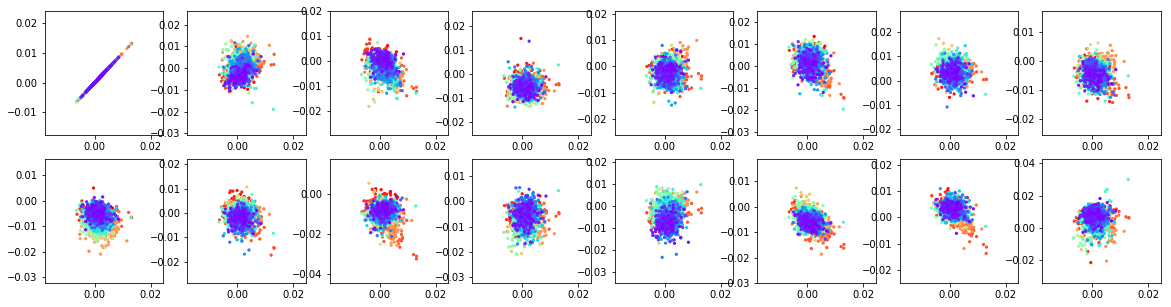

				  Average Log


In [164]:
show_embeds(np.array(average_codes).reshape(-1, model.n_z))
print('\t\t\t\t  Average Log')

In [165]:
top_codes = extract_code(top_news,10)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


1000


In [166]:
hot_codes = extract_code(hot_news, 100)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000


In [169]:
common_codes = extract_code(common_news, 10000)

/home/qara/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  del sys.path[0]


10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000


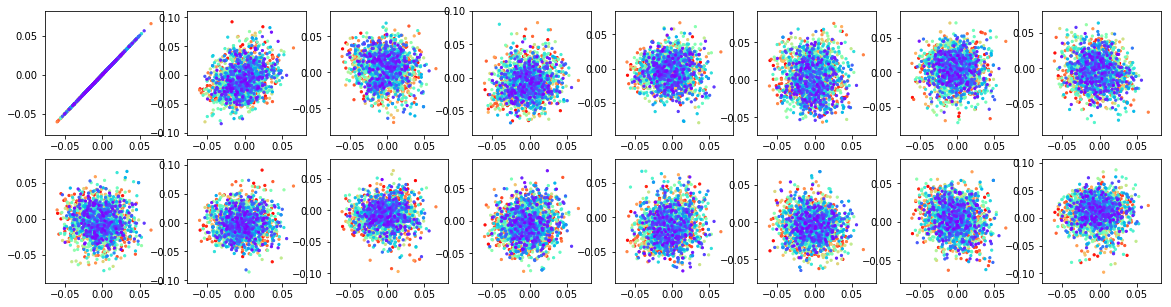

				   Top News


In [170]:
show_embeds(top_codes)
print('\t\t\t\t   Top News')

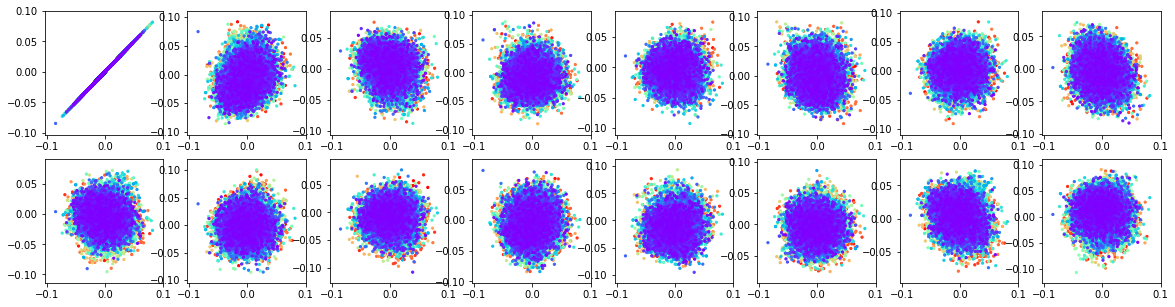

			      Hot News: ups>1000


In [171]:
show_embeds(hot_codes)
print('\t\t\t      Hot News: ups>1000')

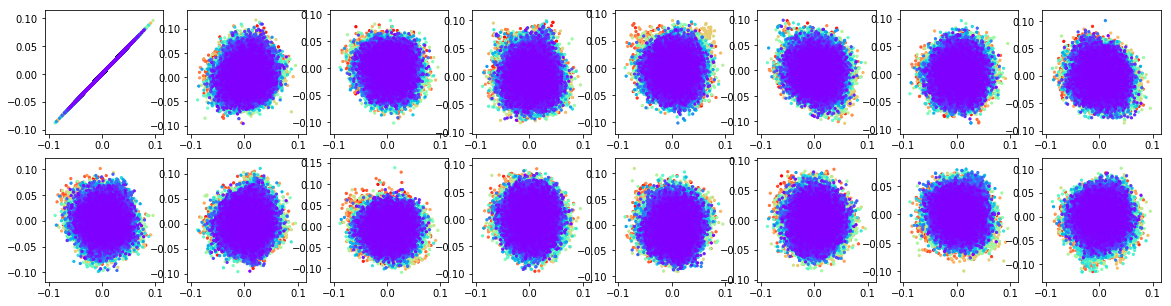

			      Common News: ups==0


In [172]:
show_embeds(common_codes)
print('\t\t\t      Common News: ups==0')